# Finding Suspect Using VAE

Ayush Thada (16BCE1333)

Sanket Deshpande

Subject: Content Based Image and Video Retrieval

<a href="https://en.wikipedia.org/wiki/Facial_composite">Facial composites</a> are widely used in forensics to generate images of suspects. Since victim or witness usually isn't good at drawing, computer-aided generation is applied to reconstruct the face attacker. One of the most commonly used techniques is evolutionary systems that compose the final face from many predefined parts.

In this project, we will try to implement an app for creating a facial composite that will be able to construct desired faces without explicitly providing databases of templates. We will apply Variational Autoencoders and Gaussian processes for this task.

### Setup
Load auxiliary files and then install and import the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
import GPy
import GPyOpt
import keras
from keras.layers import Input, Dense, Lambda, InputLayer, concatenate, Activation, Flatten, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Deconv2D
from keras.losses import MSE
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
from scipy.stats import wasserstein_distance, energy_distance, entropy
import utils
import os
%matplotlib inline

c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Model description
We will first train variational autoencoder on face images to compress them to low dimension. One important feature of VAE is that constructed latent space is dense. That means that we can traverse the latent space and reconstruct any point along our path into a valid face.

Using this continuous latent space we can use Bayesian optimization to maximize some similarity function between a person's face in victim/witness's memory and a face reconstructed from the current point of latent space. Bayesian optimization is an appropriate choice here since people start to forget details about the attacker after they were shown many similar photos. Because of this, we want to reconstruct the photo with the smallest possible number of trials.

## Generating faces

For this task, you will need to use some database of face images. There are multiple datasets available on the web that you can use: for example, <a href="http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html">CelebA</a> or <a href="http://vis-www.cs.umass.edu/lfw/">Labeled Faces in the Wild</a>. We used Aligned & Cropped version of CelebA that you can find <a href="https://www.dropbox.com/sh/8oqt9vytwxb3s4r/AADSNUu0bseoCKuxuI5ZeTl1a/Img?dl=0&preview=img_align_celeba.zip">here</a> to pretrain VAE model.

In [3]:
sess = tf.InteractiveSession()
K.set_session(sess)

latent_size = 8

vae, encoder, decoder = utils.create_vae(batch_size=128, latent=latent_size)
sess.run(tf.global_variables_initializer())
vae.load_weights('./Models/CelebA_VAE_small_8.h5')

K.set_learning_phase(False)

latent_placeholder = tf.placeholder(tf.float32, (1, latent_size))
decode = decoder(latent_placeholder)

#### Sampling from trained VAE model
As the first part of the project, we need to become familiar with the trained model. For all tasks, we will only need a decoder to reconstruct samples from a latent space.

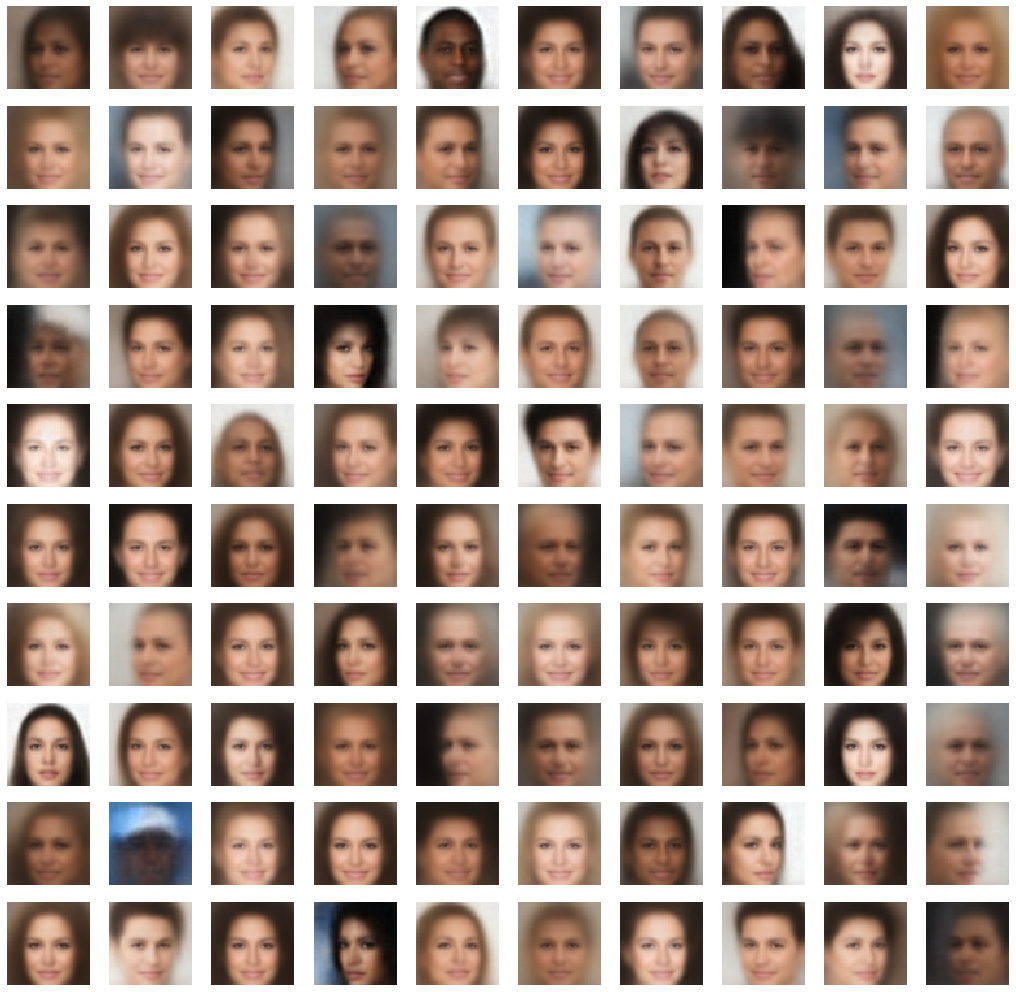

In [9]:
plt.figure(figsize=(18, 18))
for i in range(100):
    plt.subplot(10, 10, i+1)
    image = sess.run(decode, feed_dict={latent_placeholder: np.random.standard_t(df=20, size=(1,8))})[0]
    plt.imshow(np.clip(image, 0, 1))
    plt.axis('off')

#### Sampling from trained GAN model

## Search procedure

Now that we have a way to reconstruct images, we need to set up an optimization procedure to find a person that will be the most similar to the one we are thinking about. To do so, we need to set up some scoring utility. Imagine that we want to generate an image of Brad Pitt. We start with a small number of random samples, say 5, and rank them according to their similarity to your vision of Brad Pitt: 1 for the worst, 10 for the best. You then rate image by image using GPyOpt that works in a latent space of VAE. For the new image, you need to somehow assign a real number that will show how good this image is. The simple idea is to ask a user to compare a new image with previous images (along with their scores). A user then enters score to a current image.

In [15]:
def custom_ws(query_img, src_img):
    """
    Returns maximum wasserstein distance aka. earth mover distance between channels of query image and source image.
    It is average of movement(change) of pixels in query image to make it like source image
    corrosponding to least movement.
    """
    z1 = wasserstein_distance(query_img[:,:,0].reshape(-1), src_img[:,:,0].reshape(-1))
    z2 = wasserstein_distance(query_img[:,:,1].reshape(-1), src_img[:,:,1].reshape(-1))
    z3 = wasserstein_distance(query_img[:,:,2].reshape(-1), src_img[:,:,2].reshape(-1))

    return max(z1, z2, z3)

In [18]:
def custom_es(query_img, src_img):
    """
    Returns maximum energy distance between channels of query image and source image.
    It is distance between cummaltive distributions of given two distribution, in this case
    images is there as distribuion of pixels.
    """
    z1 = energy_distance(query_img[:,:,0].reshape(-1), src_img[:,:,0].reshape(-1))
    z2 = energy_distance(query_img[:,:,1].reshape(-1), src_img[:,:,1].reshape(-1))
    z3 = energy_distance(query_img[:,:,2].reshape(-1), src_img[:,:,2].reshape(-1))

    return max(z1, z2, z3)

In [19]:
def custom_kl(query_img, src_img):
    """
    Returns Kullback Leibler divergence between two probability distributions. It is the difference between the 
    expected no of bits corrosponding to quering probability distribution and expected no of bits corrosponding
    to true probability distribution.
    """
    p = np.copy(src_img)
    p = p - p.min()

    q = np.copy(query_img)
    q = q - q.min()

    p[p==0] = 1e-12
    q[q==0] = 1e-12

    z1 = entropy(p[:,:,0].reshape(-1), q[:,:,0].reshape(-1))
    z2 = entropy(p[:,:,1].reshape(-1), q[:,:,1].reshape(-1))
    z3 = entropy(p[:,:,2].reshape(-1), q[:,:,2].reshape(-1))

    return max(z1, z2, z3)

In [20]:
class FacialComposit:
    def __init__(self, decoder, latent_size):
        self.latent_size = latent_size
        self.latent_placeholder = tf.placeholder(tf.float32, (1, latent_size))
        self.decode = decoder(self.latent_placeholder)
        self.samples = None
        self.images = None
        self.rating = None

    def _get_image(self, latent):
        img = sess.run(self.decode, 
                       feed_dict={self.latent_placeholder: latent[None, :]})[0]
        img = np.clip(img, 0, 1)
        return img

    @staticmethod
    def _show_images(images, titles):
        assert len(images) == len(titles)
        clear_output()
        plt.figure(figsize=(3*len(images), 3))
        n = len(titles)
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.imshow(images[i])
            plt.title(str(titles[i]))
            plt.axis('off')
        plt.show()

    def query_initial(self, n_start=5, select_top=5, img_quality=10):
        '''
        Creates initial points for Bayesian optimization
        Generate *n_start* random images and asks user to rank them.
        Gives maximum score to the best image and minimum to the worst.
        :param n_start: number of images to rank initialy.
        :param select_top: number of images to keep
        :img_quality: Large the no, more consistent & clear images.
        '''

        self.samples = []
        self.images = []
        self.rating = []

        plt.figure(figsize=(18, 10))
        for i in range(n_start):
            self.samples.append(np.random.standard_t(df=img_quality, size=self.latent_size))
            self.images.append(self._get_image(self.samples[-1]))
            plt.subplot(2, 5, i+1)
            plt.imshow(self.images[-1])
            plt.axis('off')
        plt.show()

        self.rating = [float(x) for x in input("Assign rating between [0,10]: ").split(",")]

        idx = np.argsort(-np.array(self.rating))
        temp = min(n_start, select_top)

        self.samples = np.array(self.samples)[idx[:temp]]
        self.images = np.array(self.images)[idx[:temp]]
        self.rating = np.array(self.rating)[idx[:temp]]

        # Check that tensor sizes are correct
        np.testing.assert_equal(self.rating.shape, [select_top])
        np.testing.assert_equal(self.images.shape, [select_top, 64, 64, 3])
        np.testing.assert_equal(self.samples.shape, [select_top, self.latent_size])

    def _evaluate(self, candidate, verbose=2, method = "human"):
        '''
        Queries candidate vs known image set.
        Adds candidate into images pool.
        :param candidate: latent vector of size 1xlatent_size
        :verbose: No of set of 10 images to be print for user's supervision.
        method: ["user", "kl", "energy", "wasserstein"]
        '''
        initial_size = len(self.images)
        new_image = self._get_image(candidate[0,:])
        candidate_rating = 0
        verbose = int(np.ceil((1+initial_size)/10))

        if(method == "human"):
            plt.figure(figsize=(18, 5))
            for i in range(initial_size):
                plt.subplot(verbose, 10, i+1)
                plt.imshow(self.images[i])
                plt.title("Rating is {}".format(self.rating[i]))
                plt.axis('off')

            plt.subplot(verbose, 10, i+2)
            plt.imshow(new_image)
            plt.title("Assign Rating.")
            plt.axis('off')
            plt.show()

            candidate_rating = float(input("Enter rating: "))

        elif(method == "wasserstein"):
            score = [custom_ws(new_image, x_img) for x_img in self.images]
            candidate_rating = self.rating[np.argmin(score)]

        elif(method == "energy"):
            score = [custom_es(new_image, x_img) for x_img in self.images]
            candidate_rating = self.rating[np.argmin(score)]

        elif(method == "kl"):
            score = [custom_kl(new_image, x_img) for x_img in self.images]
            candidate_rating = self.rating[np.argmin(score)]

        self.images = np.append(self.images, new_image[None, :], axis=0)
        self.rating = np.append(self.rating, candidate_rating)
        self.samples = np.append(self.samples, candidate, axis=0)

        assert len(self.images) == initial_size + 1
        assert len(self.rating) == initial_size + 1
        assert len(self.samples) == initial_size + 1
        return candidate_rating

    def evaluate_human(self, candidate):
        return self._evaluate(candidate, method="human")

    def evaluate_energy(self, candidate):
        return self._evaluate(candidate, method="energy")

    def evaluate_kl(self, candidate):
        return self._evaluate(candidate, method="kl")

    def evaluate_ws(self, candidate):
        return self._evaluate(candidate, method="wasserstein")

    def optimize(self, n_iter=10, w=4, acquisition_type='MPI', acquisition_par=0.3, img_quality=10, solver = "human"):
        if self.samples is None:
            self.query_initial(n_start=10, select_top=10, img_quality = img_quality)

        bounds = [{'name': 'z_{0:03d}'.format(i),
                   'type': 'continuous',
                   'domain': (-w, w)} 
                  for i in range(self.latent_size)]
        
        function_name = self.evaluate_human
        if solver=="energy":
            function_name = self.evaluate_energy
        elif solver=="kl":
            function_name = self.evaluate_kl
        elif solver=="wasserstein":
            function_name = self.evaluate_ws

        optimizer = GPyOpt.methods.BayesianOptimization(f=function_name, 
                                                        domain=bounds,
                                                        acquisition_type = acquisition_type,
                                                        acquisition_par = acquisition_par,
                                                        exact_eval=False, # Since we are not sure
                                                        model_type='GP',
                                                        X=self.samples,
                                                        Y=self.rating[:, None],
                                                        maximize=True)
        optimizer.run_optimization(max_iter=n_iter, eps=-1)

    def get_best(self):
        index_best = np.argsort(-self.rating)[:5]
        return self.images[index_best]

    def draw_best(self, title=''):
        index_best = np.argsort(-self.rating)[:5]
        self._show_images(self.images[index_best], ['{} {}'.format(title, composit.rating[x]) for x in index_best])

#### Heuristics

I've created two methods of optimization which targets different aspects of the generated images.

*   **Human Methods**  : In this method we can provide rating by ourself. It is the best method as human are better than any algorithm for face recognition than any algotithm ever written. But problem with this case is that it is very slow because if it's interactive nature. 
*  **Distance Metric** : In this method, I'm using a statical distance to mesure the distance between the the stored images in the dataset and new image added. The rating of the new image is similar to one which is least unit away from the database iamges. These metrics are as follow **[Wassesterin Distance, Energy Distance, Kullback-Leibler Divergence]**

**Problem Associated**: 
*   The problem with the proposed method is that if any of the iamge in database is not rated any specific nuber between [0, 10] it will notbe assigned. Also the number which are assigned are discrete in nature, which will cause non continoues cost function. **Solution**: If we can make a small linear regressor which maps the value between the calcualted cost as regressor and the rating as response, the abve mentioned probem can be solved. 
*   There is one more issue associated with the method which is arised due to training. The distribution which we have used in training is standard normal distribuion, due to this most of the good images are generated near the mean within range of one standard deviations. **Solution**: If we use standard-t distribuion with low degree of freedom, we can assign significant probabilities to large no of values as comapred to standard normal distribution. Other dsitribution can also be tried like Laplacian distribution it too works well.
*   The final problem is there which is the decoder/image-generator itself. Rather than using the VAE decoder we can repalce it with GAN's generator, which will produce better images. But in the assignemnt we were asked to do this with VAE so I'm skipping this part.
*   Both of the method are affected by the presence of local minima. Due to which if some image gets a good rating, algorithm sample the similar images. **Solution**: To get out of the local minima or in non mathematical terms we can say when the similar images repeats, we can give very high penalty like -10 or -40 to image and it will surely make us out of that place with very high probability.



## Testing our algorithm

In these sections, we will apply the implemented app to search for different people. Each task will ask you to generate images that will have some property like "dark hair" or "mustache". We need to run your search algorithm and provide the best discovered image.

#### Finding person with darkest hair

In [11]:
# If certain image repeates give it very high negative penalty, new image will come.

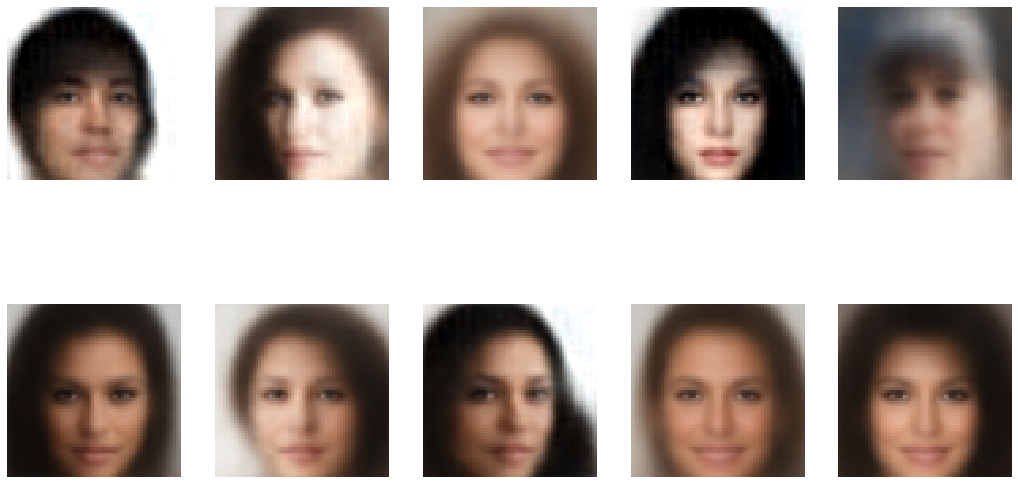

Assign rating between [0,10]: 6,5,2,10,1,9,4,8,3,7


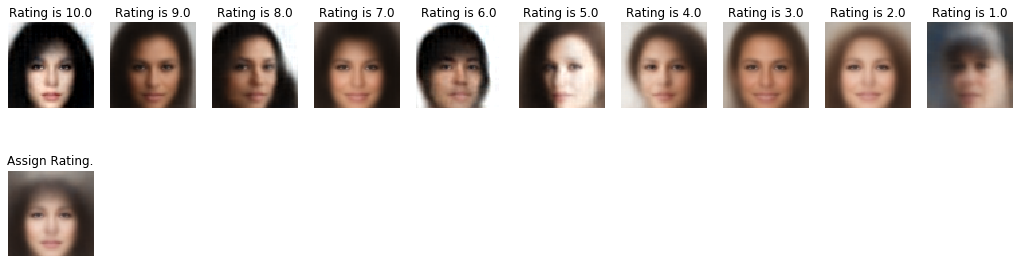

Enter rating: 5.2


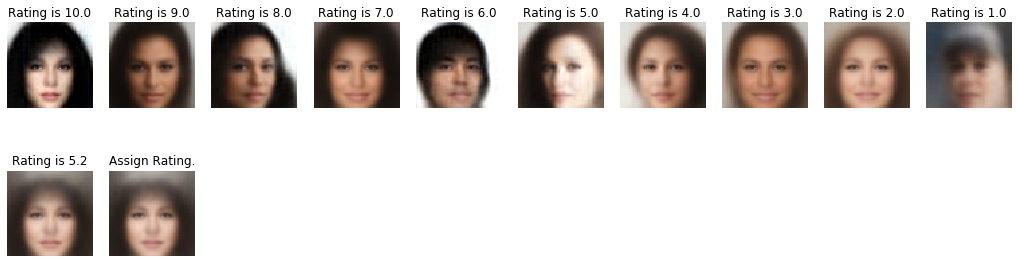

Enter rating: 5.2


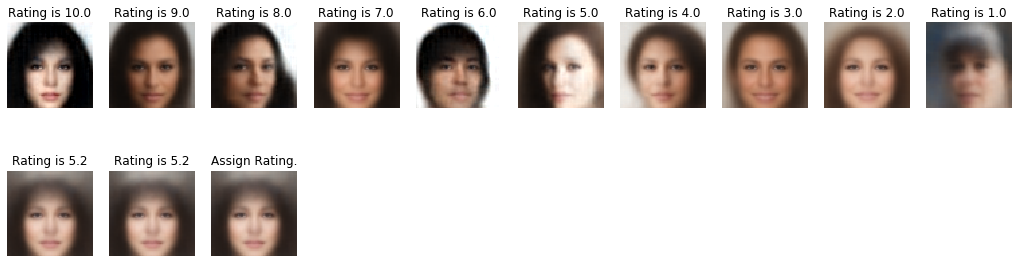

Enter rating: -10


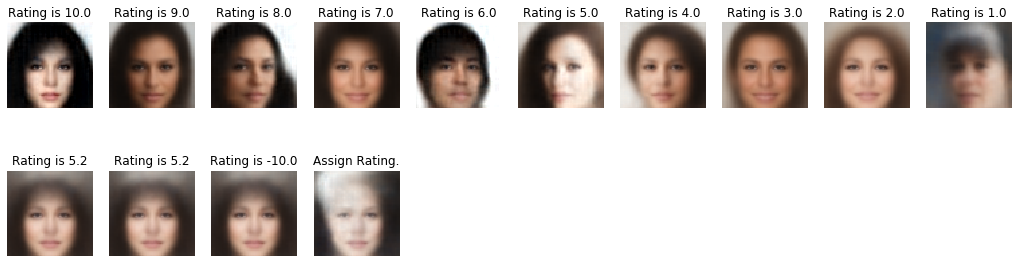

Enter rating: -40


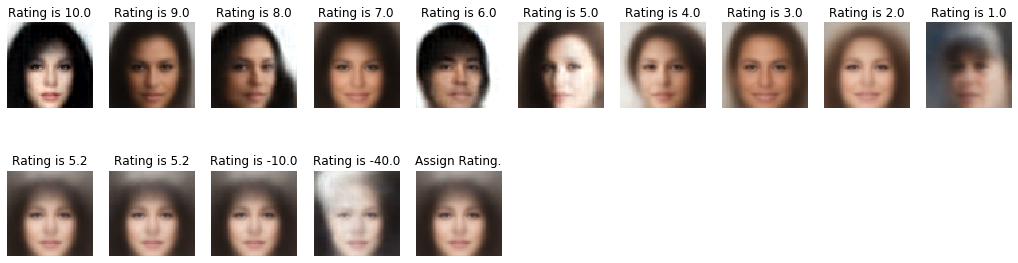

Enter rating: 5


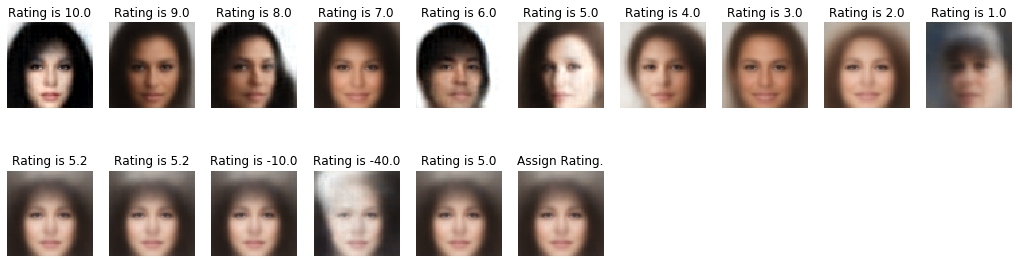

Enter rating: -5


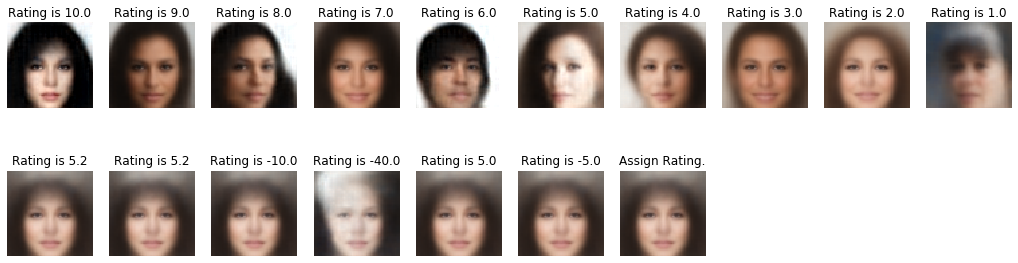

Enter rating: -20


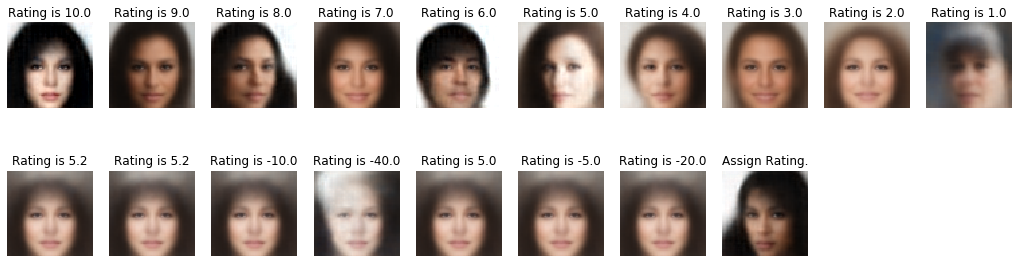

Enter rating: 8.0


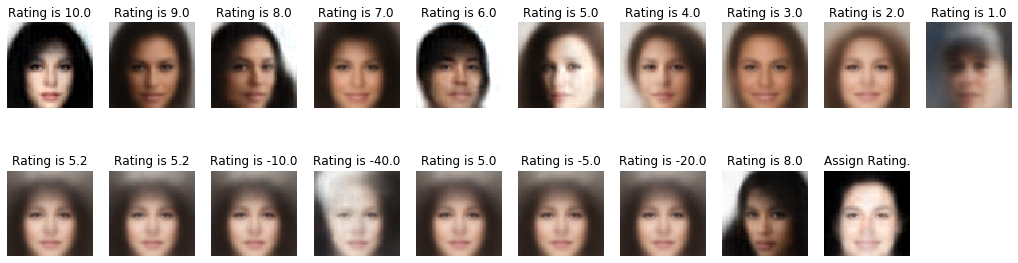

Enter rating: 9.2


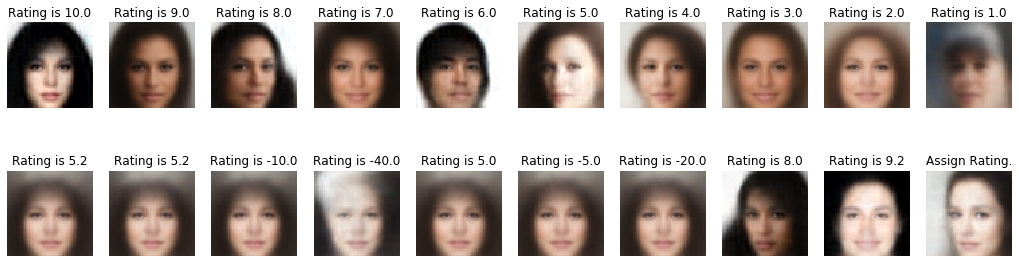

Enter rating: 4.5


In [12]:
# Human Interaction Method

composit = FacialComposit(decoder, 8)
composit.optimize(solver="human", img_quality=4)

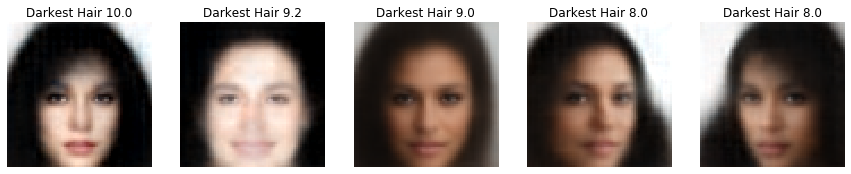

In [13]:
# Human Solver
composit.draw_best('Darkest Hair')

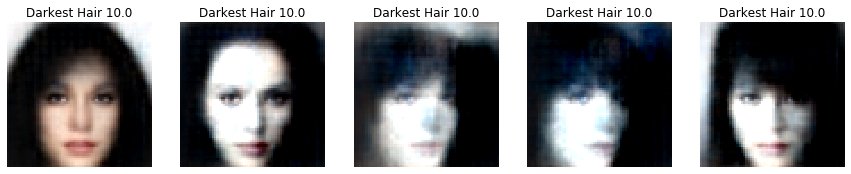

In [21]:
# Energy Solver
composit.optimize(solver="energy", img_quality=8, n_iter=20, w=5)
composit.draw_best('Darkest Hair')

#### Finding person with the widest smile

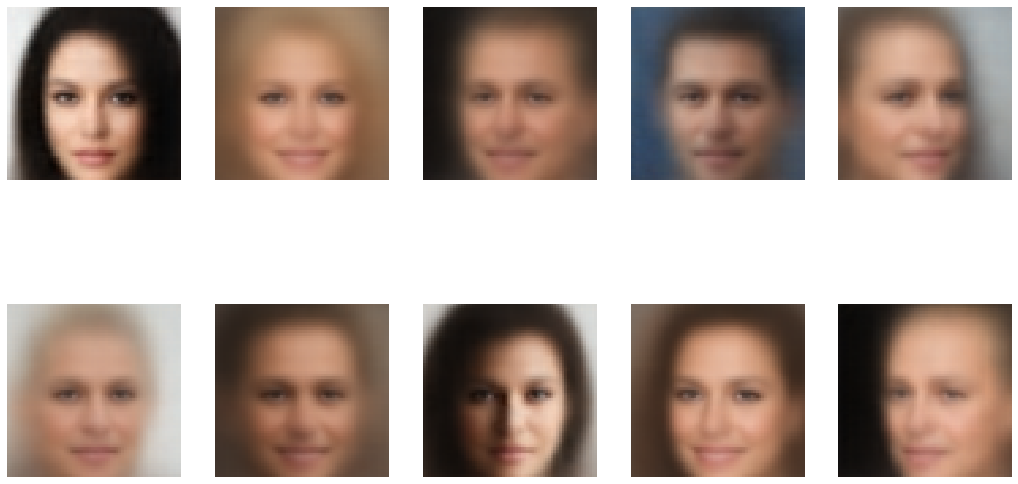

Assign rating between [0,10]: 1,8,7,5,6,4,9,2,10,3


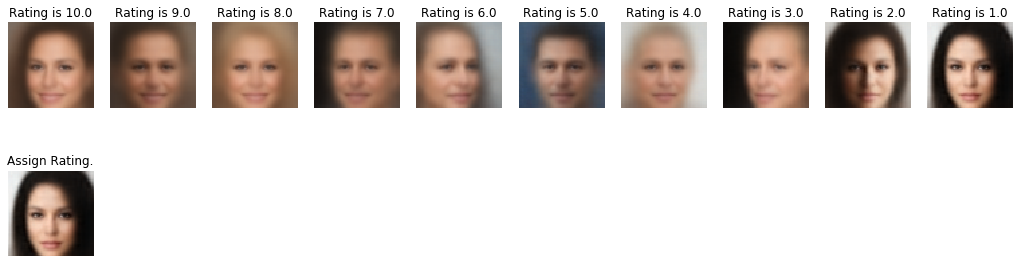

Enter rating: 4.5


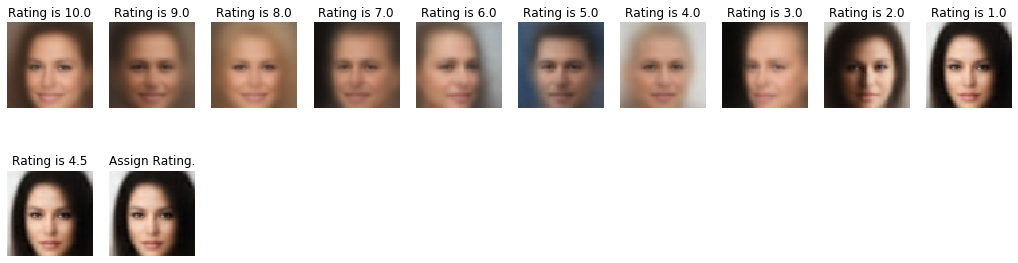

Enter rating: 4.2


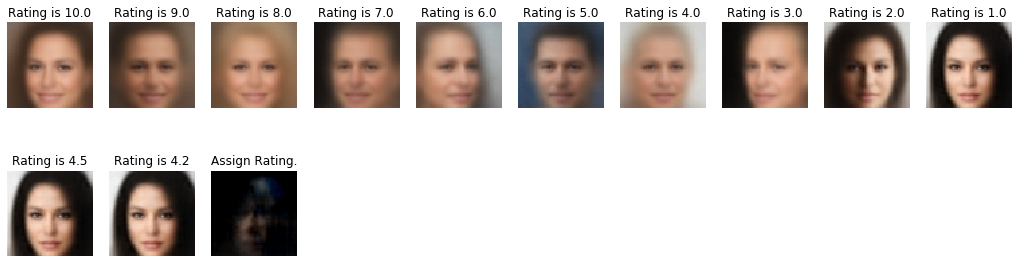

Enter rating: -10


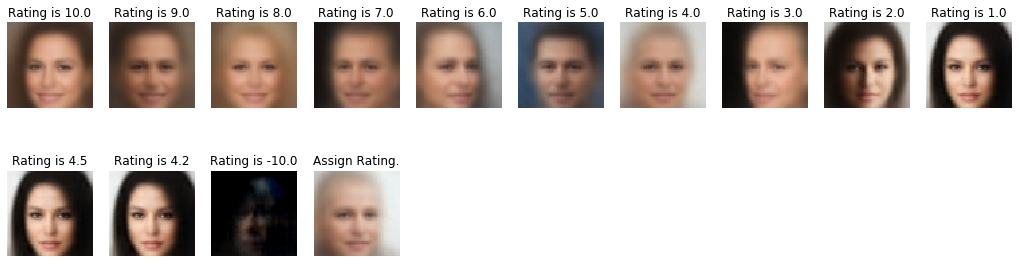

Enter rating: 7.0


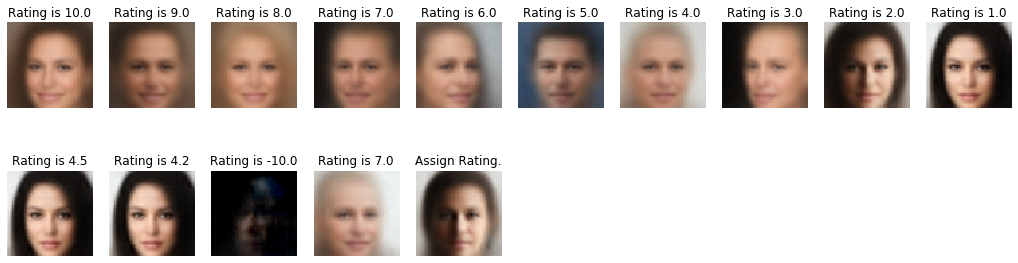

Enter rating: 3.5


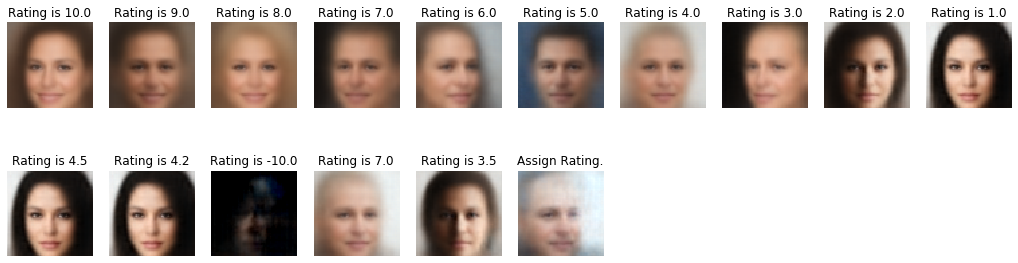

Enter rating: 6.2


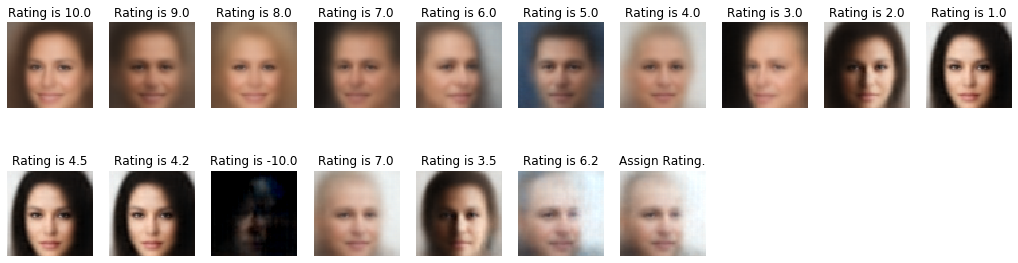

Enter rating: 6.4


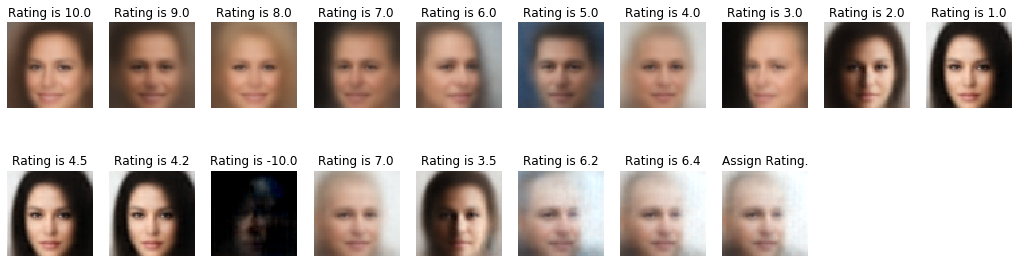

Enter rating: -10


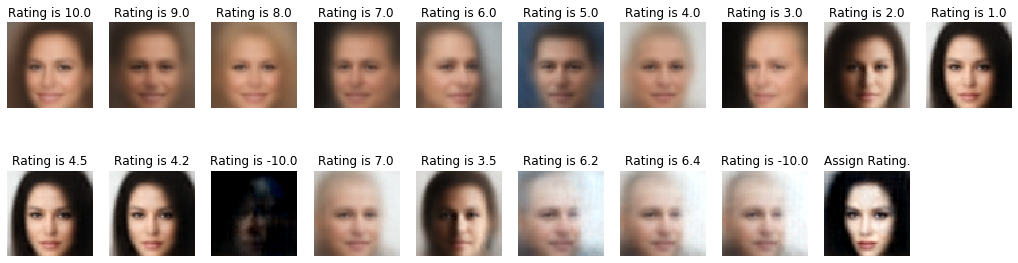

Enter rating: 4.8


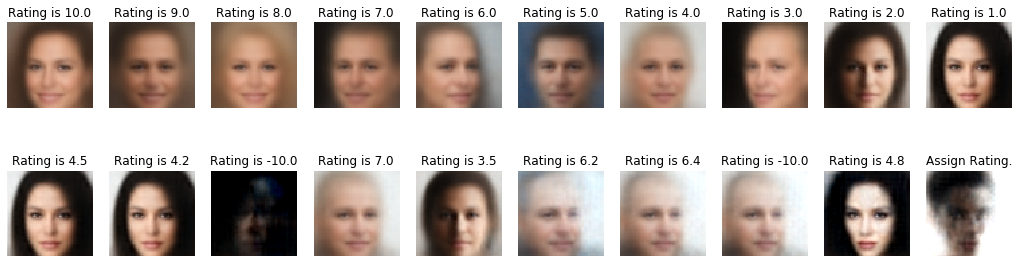

Enter rating: 0


In [22]:
composit = FacialComposit(decoder, 8)
composit.optimize(solver="human", img_quality=8)

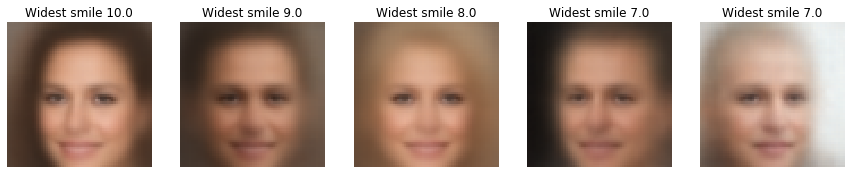

In [23]:
# Human Solver
composit.draw_best('Widest smile')

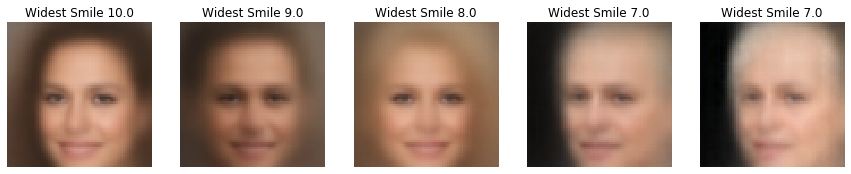

In [24]:
# KL Solver
composit.optimize(solver="kl", img_quality=10, n_iter=20, w=2)
composit.draw_best('Widest Smile')

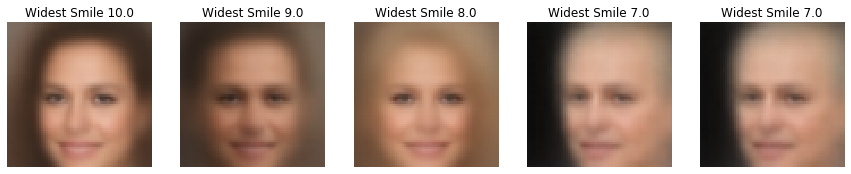

In [25]:
# Wasserstein Solver
composit.optimize(solver="wasserstein", img_quality=10, n_iter=20, w=10)
composit.draw_best('Widest Smile')